## Movie Recommendation System for Turner Classic Movies

# Objective
A Recommendation system for older movies for the movie network Turner Classic Movies

# Business Understanding
Amidst large scale changes in viewing habits and content consumption via Cable and Streaming platforms, the importance of engagement with Warner Bros. older film library and older films in general is at an all time high for the profitable cable pay-network of Turner Classic Movies.

A Recommendation system for a younger generation to rate new releases that they have seen and be given high quality recommendations for older movies they may not know about will drive network engagement and profit.

# Data Understanding
- Data was provided from grouplens.org MovieLens 25 million review database released 12/2019.
- The database contains 62,000 movies rated by 162,000 users.
- The Data was filtered to movies released up until 1969 as the network focuses on 'classic' movies from the 30s through 60s.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

In [2]:
movies_df = pd.read_csv('data/ml-25m/ml-25m/movies.csv')
ratings_df = pd.read_csv('data/ml-25m/ml-25m/ratings.csv')

In [3]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')

In [6]:
movies_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [7]:
movies_df['year'].isna().sum()

410

In [8]:
movies_df = movies_df.dropna(subset=['year'])

In [9]:
movies_df['year'].isna().sum()

0

In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62013 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62013 non-null  int64 
 1   title    62013 non-null  object
 2   genres   62013 non-null  object
 3   year     62013 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [11]:
movies_df_old = movies_df.copy()

In [12]:
movies_df_old['year'] = movies_df_old['year'].astype(int)

Filtering Movies to include only movies from before 1969 (For TCM) and after 2015 (Recent Movies to base recommendations off of)

In [13]:
movies_df_clean = movies_df_old[((movies_df_old['year'] <= 1969) & (movies_df_old['year'] >= 1927)) | (movies_df_old['year'] >= 2017)]

In [14]:
movies_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16620 entries, 152 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  16620 non-null  int64 
 1   title    16620 non-null  object
 2   genres   16620 non-null  object
 3   year     16620 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 584.3+ KB


In [15]:
movies_df_final = movies_df_clean.copy()

In [16]:
movies_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16620 entries, 152 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  16620 non-null  int64 
 1   title    16620 non-null  object
 2   genres   16620 non-null  object
 3   year     16620 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 584.3+ KB


In [20]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [21]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [22]:
ratings_df_clean = ratings_df.drop(columns='timestamp')

In [23]:
ratings_df_clean.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [24]:
ratings_df_final = ratings_df_clean[ratings_df_clean['movieId'].isin(movies_df_final['movieId'])]

In [25]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038963 entries, 4 to 25000019
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 62.2 MB


# EDA

In [26]:
movies_df_final.reset_index(inplace=True, drop=True)

In [27]:
movies_df_final

,movieId,title,genres,year
0,154,Beauty of the Day (Belle de jour) (1967),Drama,1967
1,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance,1964
2,390,Faster Pussycat! Kill! Kill! (1965),Action|Crime|Drama,1965
3,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,1937
4,596,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940
...,...,...,...,...
16615,209147,The Carpet of Horror (1962),Crime|Horror,1962
16616,209151,Mao Zedong 1949 (2019),(no genres listed),2019
16617,209157,We (2018),Drama,2018
16618,209163,Bad Poems (2018),Comedy|Drama,2018


In [28]:
ratings_df_final.reset_index(inplace=True, drop=True)

In [29]:
ratings_df_final

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5.0
2,1,1250,4.0
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
2038958,162541,969,4.0
2038959,162541,1029,3.5
2038960,162541,1201,3.0
2038961,162541,2080,4.0


In [30]:
movies_and_ratings_df = pd.merge(movies_df_final, ratings_df_final, on='movieId', how='right')

In [31]:
movies_and_ratings_df

,movieId,title,genres,year,userId,rating
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1952,1,3.5
1,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1952,31,4.0
2,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1952,58,5.0
3,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1952,59,3.5
4,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1952,72,5.0
...,...,...,...,...,...,...
2038958,200238,Love at First Sight (2017),Animation|Children|Comedy|Romance,2017,162067,3.0
2038959,200240,System Error (2018),Documentary,2018,162067,3.0
2038960,200242,Gunter Babysits (2017),Animation|Comedy,2017,162067,2.0
2038961,200634,Eddie's Life Coach (2017),Animation|Children,2017,162067,2.5


Graph most popular movies by number of ratings, average rating

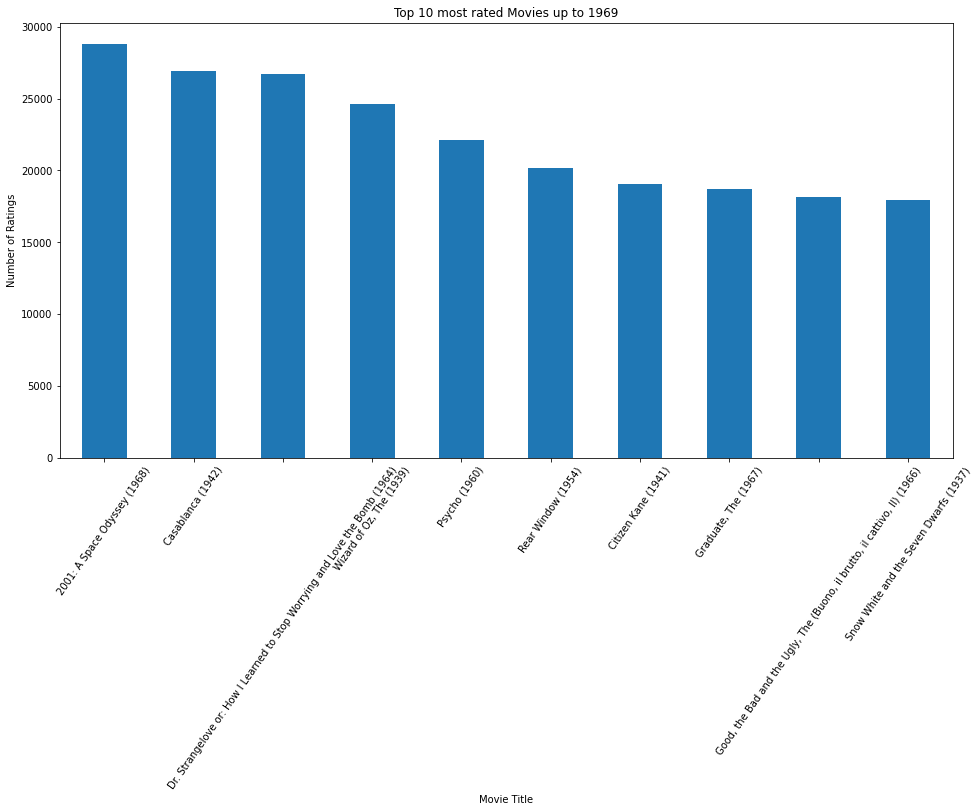

In [234]:
movies_and_ratings_df['title'].value_counts(sort=True).head(10).plot(
    figsize = (16, 8),
    kind = 'bar',
    title = 'Top 10 most rated Movies up to 1969',
    ylabel = 'Number of Ratings',
    xlabel = 'Movie Title',
    );
plt.xticks(rotation=55);

These Movies might have an effect on modeling recommendations because of their number of reviews.

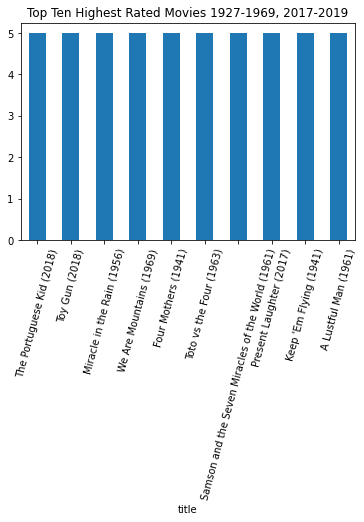

In [225]:
movies_and_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(
    kind='bar',
    title='Top Ten Highest Rated Movies 1927-1969, 2017-2019',);
plt.xticks(rotation=75);

These Movies might only have 1 5 star rating not necessarily the best overall movies.

# Modeling

In [34]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038963 entries, 0 to 2038962
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 46.7 MB


Converting datatypes to less memory intensive units

In [35]:
ratings_df_modeling = ratings_df_final.copy()

In [36]:
ratings_df_modeling['rating'] = ratings_df_modeling['rating'].astype(np.float32)

In [37]:
ratings_df_modeling['userId'] = ratings_df_modeling['userId'].astype(np.int32)

In [38]:
ratings_df_modeling['movieId'] = ratings_df_modeling['movieId'].astype(np.int32)

In [39]:
ratings_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038963 entries, 0 to 2038962
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 23.3 MB


Taking a random sample from dataset to model on because of memory limitations causing crashes.

In [40]:
sampled_df = ratings_df_modeling.sample(frac=0.2, random_state=42)

In [41]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407793 entries, 1395195 to 1291314
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   407793 non-null  int32  
 1   movieId  407793 non-null  int32  
 2   rating   407793 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 7.8 MB


In [42]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sampled_df, reader)

In [43]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  76814 

Number of items:  9336


More efficient to use item-item similarity because there are less items than users.

In [44]:
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [45]:
def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

## Baseline KNN Basic Model with pearson correlation and item-item similarity.

In [46]:
baseline_knn_model = KNNBasic(sim_options={'name':'pearson', 'user_based':False})
train_and_test_pred(baseline_knn_model, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.4827
0.4826913017398649
MAE:  0.3393
0.3393004743195254
unbiased accuracy on test set: 
RMSE: 0.9492
0.9491948257262302
MAE:  0.7042
0.7041541612686528


In [47]:
cv_knn_basic = cross_validate(baseline_knn_model, data, n_jobs=-1)

In [48]:
print(np.mean(cv_knn_basic['test_rmse']))
print(np.mean(cv_knn_basic['test_mae']))

0.949150929668612
0.704596664924092


## Baseline KNNBasic model with no hyperparameter tuning has cross-validation RMSE of .95 and MAE of .705

In [49]:
#Gridsearch KNN Basic Model to see best params for KNN Basic
params = {'k': [30, 40, 50],
         'sim_options': {'name':['cosine', 'pearson', 'pearson_baseline'],
                        'user_based': [False]}
         }
KNNBasic_gridsearch = GridSearchCV(KNNBasic, param_grid = params, n_jobs=-1)
KNNBasic_gridsearch.fit(data)

In [50]:
print(KNNBasic_gridsearch.best_params)
print(KNNBasic_gridsearch.best_score)

{'rmse': {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}}, 'mae': {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}}}
{'rmse': 0.9260501830287706, 'mae': 0.6906019395938696}


In [51]:
KNNBasic_best = KNNBasic_gridsearch.best_estimator['mae']
train_and_test_pred(KNNBasic_best, trainset, testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.7094
0.7094377950688799
MAE:  0.5110
0.5110458859697224
unbiased accuracy on test set: 
RMSE: 0.9254
0.925387244200347
MAE:  0.6895
0.6894858809060073


In [52]:
cv_best_knnbasic = cross_validate(KNNBasic_best, data)
print(np.mean(cv_best_knnbasic['test_rmse']))
print(np.mean(cv_best_knnbasic['test_mae']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
0.9246817189124579
0.6894086634155497


# KNN Basic tuned model has RMSE of .925 and MAE of .689, a small improvement from KNN Basic baseline model RMSE of .95 and MAE of .705.

# KNNBaseline Model

In [53]:
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':False})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [54]:
train_and_test_pred(knn_baseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.4419
0.44194945162470767
MAE:  0.3108
0.3107694672158219
unbiased accuracy on test set: 
RMSE: 0.8854
0.8854411771927995
MAE:  0.6572
0.6571896647861761


# KNNBaseline model has RMSE of .885 and MAE of .657, a small improvement over KNNBasic.

# SVD Modeling

In [55]:
svd=SVD()
cv_svd = cross_validate(svd, data)

In [56]:
print(np.mean(cv_svd['test_rmse']))
print(np.mean(cv_svd['test_mae']))

0.8615639152387884
0.6577846105611334


Baseline SVD RMSE is .862 and MAE is .658

In [57]:
## Gridsearch with SVD
params = {'n_factors': [50, 100, 150],
          'reg_all': [0.02, 0.05, 0.07],
          'n_epochs': [20, 40],
          'lr_all': [0.005, 0.007]}

SVD_gridsearch = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
SVD_gridsearch.fit(data)

In [58]:
print(SVD_gridsearch.best_score)
print(SVD_gridsearch.best_params)

{'rmse': 0.8402675303694271, 'mae': 0.63961801012146}
{'rmse': {'n_factors': 50, 'reg_all': 0.07, 'n_epochs': 40, 'lr_all': 0.007}, 'mae': {'n_factors': 50, 'reg_all': 0.07, 'n_epochs': 40, 'lr_all': 0.007}}


In [59]:
SVD_best = SVD_gridsearch.best_estimator['mae']

In [60]:
train_and_test_pred(SVD_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.6056
0.6056042160028657
MAE:  0.4676
0.4676199544006789
unbiased accuracy on test set: 
RMSE: 0.8412
0.8412045075362942
MAE:  0.6408
0.6408321266971911


In [61]:
cv_best_svd = cross_validate(SVD_best, data)
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))
print("mean test mae", np.mean(cv_best_svd['test_mae']))

mean test rmse 0.8401570352616956
mean test mae 0.6396446429399758


# Tuned SVD model RMSE of .84 and MAE of .64 is best performing model so far.

# NMF Model

In [62]:
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print(np.mean(cv_nmf['test_rmse']))
print(np.mean(cv_nmf['test_mae']))

0.9349454540554639
0.7116238805832533


Baseline NMF RMSE .935  and MAE .712

In [63]:
params = {'n_factors': [10, 15, 20],
          'n_epochs': [25, 50, 75],
          'reg_pu': [.06, .08],
          'reg_qi': [.06, .08],
          'biased': [True, False]}

nmf_gridsearch = GridSearchCV(NMF, param_grid = params, n_jobs=-1)
nmf_gridsearch.fit(data)

In [65]:
print(nmf_gridsearch.best_params)
print(nmf_gridsearch.best_score)

{'rmse': {'n_factors': 10, 'n_epochs': 75, 'reg_pu': 0.08, 'reg_qi': 0.08, 'biased': True}, 'mae': {'n_factors': 10, 'n_epochs': 75, 'reg_pu': 0.08, 'reg_qi': 0.08, 'biased': True}}
{'rmse': 0.8691247110606302, 'mae': 0.6676975369024267}


In [66]:
nmf_best = nmf_gridsearch.best_estimator['mae']
train_and_test_pred(nmf_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.5891
0.589055841133963
MAE:  0.4352
0.4352397844699101
unbiased accuracy on test set: 
RMSE: 0.8725
0.8725471543465879
MAE:  0.6705
0.6705460146891714


In [67]:
cv_best_nmf = cross_validate(nmf_best, data)
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))
print("mean test mae", np.mean(cv_best_nmf['test_mae']))

mean test rmse 0.8703207959195284
mean test mae 0.6693338699947485


Tuned NMF Model has RMSE .87 of and MAE of .67 making it 2nd best model behind SVD

# Best Model is SVD and will be used in recommendation functions below

In [68]:
best_model = SVD(n_factors=50, n_epochs=40, reg_all=.07, lr_all=.007)
best_model.fit(trainset)

In [69]:
best_model.test(testset)
accuracy.rmse(best_model.test(testset))

RMSE: 0.8424


0.8424061248451759

In [70]:
accuracy.mae(best_model.test(testset))

MAE:  0.6411


0.6411046639448749

Simple prediction

In [71]:
best_model.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.4920175071170085, details={'was_impossible': False})

## Function for a user to rate newer movies (2017-2019)

In [215]:
def movie_rater(movies_df_final, num, year=2017):
    userID = 110000
    rating_list = []
    while num > 0:
        if year:
            movie = movies_df_final[movies_df_final['year'] >= year].sample(1)
        else:
            movie = movies_df_final.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [216]:
user_rating = movie_rater(movies_df_final, 3)

       movieId               title          genres  year
11783   184925  Errementari (2018)  Fantasy|Horror  2018
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
       movieId            title       genres  year
12452   188513  End Game (2018)  Documentary  2018
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                   title              genres  year
7194   143387  Pitch Perfect 3 (2017)  (no genres listed)  2017
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
       movieId                  title  genres  year
14203   197209  The Last Laugh (2019)  Comedy  2019
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5


In [217]:
user_rating

[{'userId': 110000, 'movieId': 188513, 'rating': '5'},
 {'userId': 110000, 'movieId': 143387, 'rating': '5'},
 {'userId': 110000, 'movieId': 197209, 'rating': '5'}]

In [218]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([ratings_df_final, user_ratings], axis=0)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [219]:
new_ratings_df

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5
2,1,1250,4
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
2038961,162541,2080,4
2038962,162541,2947,1.5
0,110000,188513,5
1,110000,143387,5


In [220]:
svd_ = SVD(n_factors=50, n_epochs=40, reg_all=.07, lr_all=.007)
svd_.fit(new_data.build_full_trainset())

In [221]:
list_of_movies = []
for m_id in ratings_df_final['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(110000,m_id)[3]))

In [222]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

## Function to Recommend movies from 1927-1969 based off modern movie ratings

In [223]:
def recommended_movies(user_ratings, movies_df_final, n):
    for idx, rec in enumerate(user_ratings):
        title = movies_df_final.loc[(movies_df_final['movieId'] == int(rec[0])) & (movies_df_final['year'] <= 1969)]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies, movies_df_final, 3)

Recommendation #  1 :  147    12 Angry Men (1957)
Name: title, dtype: object 

Recommendation #  2 :  14    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  31    Rear Window (1954)
Name: title, dtype: object 

